<h1 style = "font-size:30px;"> Predicting impact </h1>

<h3> Given the text in ticket predict its category. Essentially its a 5 class classification problem. </h3>

In [0]:
import pandas as pd
import numpy as np

<h2> 1. Data loading </h2>

In [2]:
fname = "all_tickets.csv"

df = pd.read_csv(fname)
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


<h2> 2. Data preprocessing </h2>

In [0]:
# Importing libraries required for text preprocessing

import re    # Regex parsing
from nltk.corpus import stopwords   # For stopword removal
from nltk.stem import WordNetLemmatizer    # For stemming words

stops = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

# Utilities for text preprocessing
def txt_preprocess(x):
    
    x = str(x).lower()
    
    # Replacing unwanted texts
    x = x.replace("′", "'")
    x = x.replace("’", "'")
    x = x.replace("won't", "will not")
    x = x.replace("cannot", "can not")
    x = x.replace("can't", "can not")
    x = x.replace("n't", " not")
    x = x.replace("what's", "what is")
    x = x.replace("it's", "it is")
    x = x.replace("'ve", " have")
    x = x.replace("i'm", "i am")
    x = x.replace("'re", " are")
    x = x.replace("he's", "he is")
    x = x.replace("she's", "she is")
    x = x.replace("'s", " own")
    x = x.replace("%", " percent ")
    x = x.replace("'ll", " will")
    
    # Tokenizing text
    words = x.split(" ")    
    # Removing stopwords
    words = [word for word in words if word not in stops]
    # Lemmatizing words,i.e , replace word with corresponding root word.
    words = [lemmatizer.lemmatize(word) for word in words]
    # Words containing only alphabets
    words = [word for word in words if word.isalpha()]
    # Joining the words back
    x = (" ").join(words)
    
    return x

In [4]:
df["body"] = df["body"].fillna("").apply(txt_preprocess)
df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineer ...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,expire day hi ask help update password colleag...,1,4,2,76,4,3,4


In [0]:
texts = df["body"]
labels = pd.get_dummies(df["impact"]).values

<h2> 3. Preparing the data for training </h2>

<h3> 3.1 Text to integer encodings </h3>

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
training_samples = 44000
validation_samples = df.shape[0] - training_samples
maxlen = 50
maxwords = 10000

In [8]:
tokenizer = Tokenizer(num_words=maxwords)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=maxlen, padding="post")
data

Found 10486 unique tokens.


array([[   3,  196, 1781, ...,    0,    0,    0],
       [ 923,   14,    1, ...,    0,    0,    0],
       [  44,  605,   29, ...,    0,    0,    0],
       ...,
       [   8,   12,   18, ...,    0,    0,    0],
       [   8,   12,   18, ...,    0,    0,    0],
       [   6,    1,  132, ...,    0,    0,    0]], dtype=int32)

<h3> 3.2 Preparing the embedding matrix </h3>

In [9]:
embedding_dir = "glove.6B.100d.txt"
embedding_index = dict()  # Key: word, Value: embedding vector

# Opening the file containing GLoVe embeddings
f = open(embedding_dir, encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embed_size = 100
embedding_matrix = np.zeros((vocab_size, embed_size))
absent_words = 0

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found would be all zeros
        embedding_matrix[i] = embedding_vector
    else:
        print(word)
        absent_words += 1
        
print('Total absent words are', absent_words, 'which is', 
      "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

timecard
nonrecoverable
intr
req
unapplied
unlinking
greyed
fulfiller
receipting
locomote
cooky
msec
updaters
rcpt
qty
keyset
retries
receipted
notifier
reseat
assignat
async
distr
inconsistences
convertor
inters
incase
transactor
resubmissions
sharable
promptitude
rebill
vised
allocable
reseating
homeworker
holydays
certes
celling
instr
automatize
cosec
fulfillers
engager
decapsulate
capacitate
rejecter
mistyping
limitative
unclarified
eely
yabber
recopy
sayst
subtask
troubleshot
scanter
vatic
connecter
reeving
itemization
automatization
recept
earnable
chestier
requestors
spited
reshaper
countersignature
coachers
staled
architecure
fetchers
deselect
plier
takeing
numerate
dumbs
etape
mktg
valuta
existents
builded
sherd
accessability
mistype
surger
adverted
belows
closuring
suppler
doest
bulleting
fallowed
handwrite
transferal
automatized
resoled
pragmatical
internality
incommode
insipidity
laten
demagnetized
trued
inutile
concatenate
roomer
snappiness
unbind
rebind
formating
curser
s

<h2> 4. Train-Test split </h2>

In [0]:
np.random.seed(7)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [0]:
# Sanity check
assert(x_train.shape[0] == y_train.shape[0])
assert(x_val.shape[0] == y_val.shape[0])

<h2> 5. Performance visualization </h2>

In [0]:
# Importing necessary libraries 

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y,num_classes):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    plt.figure(figsize=(7,3))
    
    labels = [i for i in range(num_classes)]
    
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.show()

<h2> 6. Finding class weights </h2>

In [0]:
def flatten_one_hot(y_true):

  labels = []

  for one_hot_label in y_true:
    labels.append(np.argmax(one_hot_label))

  labels = np.array(labels)
  return labels

In [14]:
from sklearn.utils import class_weight

y_train_labels = flatten_one_hot(y_train)
class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train_labels), y_train_labels)
class_weight

array([ 20.37037037, 204.65116279,  43.56435644,   0.73670992,
         0.28045127])

In [0]:
def plot_metrics(hist, num_epochs):
  
  acc = hist.history["categorical_accuracy"]
  val_acc = hist.history["val_categorical_accuracy"]

  loss = hist.history["loss"]
  val_loss = hist.history["val_loss"]
  
  epochs = range(num_epochs)
  
  plt.figure(figsize=(10,7))
  
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'b', label="Accuracy")
  plt.plot(epochs, val_acc, 'r', label="Validation Accuracy")
  plt.grid()
  plt.legend()
  
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'b', label="Loss")
  plt.plot(epochs, val_loss, 'r', label="Validation Loss")
  plt.grid()
  plt.legend()  
  
  plt.show()

<h2> 6. Training models </h2>

<h3> 6.1 Using LSTM</h3>

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, CuDNNLSTM, Dense, SpatialDropout1D, GlobalMaxPooling1D, Dropout

In [20]:
e = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length=50, trainable=True)
num_classes = 5

model1 = Sequential()
model1.add(e)
model1.add(SpatialDropout1D(0.2))
model1.add(CuDNNLSTM(64, return_sequences=True))
model1.add(GlobalMaxPooling1D())
model1.add(Dense(128, activation="relu"))
model1.add(Dropout(0.25))
model1.add(Dense(num_classes, activation="softmax", name="Output"))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           1048700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 50, 64)            42496     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
Output (Dense)               (None, 5)                 645       
Total para

In [0]:
from keras.optimizers import Adam

model1.compile(optimizer=Adam(lr=1e-4),
             loss="categorical_crossentropy",
             metrics=["categorical_accuracy"])

In [23]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filename = 'baseline.h5'
num_epochs = 15
Batch_size = 128

es = EarlyStopping(monitor='val_loss', mode='min', baseline=0.2, verbose=1, patience=15)
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5)

# fit model
hist1 = model1.fit(x_train, y_train, epochs=num_epochs, batch_size=Batch_size, validation_data=(x_val,y_val), 
                 callbacks=[es,checkpoint,reduce_lr], verbose=1)

Train on 44000 samples, validate on 4549 samples
Epoch 1/15
44000/44000 [==============================] - 3s 61us/step - loss: 0.0979 - categorical_accuracy: 0.9728 - val_loss: 0.1084 - val_categorical_accuracy: 0.9694

Epoch 00001: val_loss improved from inf to 0.10839, saving model to baseline.h5
Epoch 2/15
44000/44000 [==============================] - 3s 60us/step - loss: 0.0968 - categorical_accuracy: 0.9732 - val_loss: 0.0981 - val_categorical_accuracy: 0.9719

Epoch 00002: val_loss improved from 0.10839 to 0.09807, saving model to baseline.h5
Epoch 3/15
44000/44000 [==============================] - 3s 58us/step - loss: 0.0940 - categorical_accuracy: 0.9738 - val_loss: 0.0960 - val_categorical_accuracy: 0.9725

Epoch 00003: val_loss improved from 0.09807 to 0.09602, saving model to baseline.h5
Epoch 4/15
44000/44000 [==============================] - 3s 59us/step - loss: 0.0910 - categorical_accuracy: 0.9751 - val_loss: 0.0943 - val_categorical_accuracy: 0.9732

Epoch 00004: va

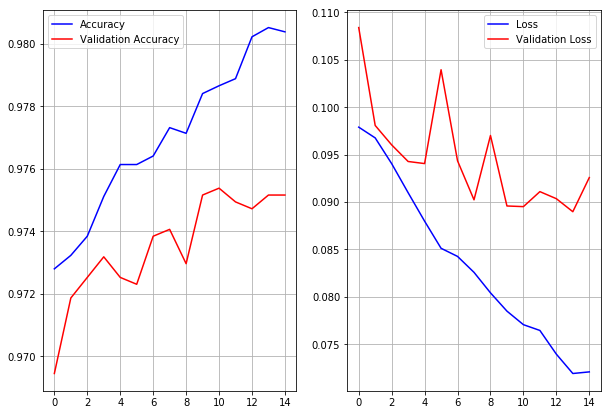

In [27]:
plot_metrics(hist1, num_epochs)

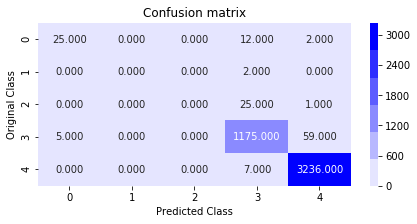

In [26]:
y_pred = model1.predict_classes(x_val)
y_test = flatten_one_hot(y_val)

plot_confusion_matrix(y_test, y_pred, 5)